In [2]:
import numpy as np
import wandb
from tqdm import trange
from util.mnist.tools import *
from util.pickleInterface import *
from util.whatwhere.encoder import *
from util.whatwhere.decoder import *
from util.whatwhere.noise import *
from util.willshaw.memory import *
from util.willshaw.plot import *
from util.pytorch.tools import np_to_grid
from util.distribution import *
from util.basic_utils import mse_detailed
from util.whatwhere.description_encoding import *
from util.whatwhere.generate import *


In [18]:
def plot_sparsity_hist(codes, legend="", nbins=100, title="", flip=False):
    ones_per_code = np.sum(codes,axis=-1)
    if flip:
        plt.hist(ones_per_code, bins=nbins, density=True, label = legend, orientation='horizontal')
        plt.ylabel("number of active bits")
        plt.xlabel("frequency")
    else:
        plt.hist(ones_per_code, bins=nbins, density=True, label = legend)
        plt.xlabel("number of active bits")
        plt.ylabel("frequency")
        
    plt.xlim([0,1000])
    plt.ylim([0,0.05])
    plt.title(title)
    plt.legend()

In [7]:
""" Code generation parameters """
rng = np.random.RandomState(0)  # reproducible
K = 20
Q = 21
n_epochs = 5
b = 0.8
wta = True
Fs = 2
T_what = 0.75

""" load mnist """
imgs, lbls, tst_imgs, tst_lbls = read_mnist(n_train=60000)
I = imgs.shape[1]
J = imgs.shape[2]

""" generate codes """
features = compute_features(imgs, lbls, K, Fs, rng, n_epochs, b, verbose=False)
codes, polar_params = compute_codes(
    imgs,
    K,
    Q,
    features,
    T_what,
    wta,
    n_epochs,
    b,
    Fs,
    verbose=False,
    set="trn"
)

code_size = codes.shape[1]

In [8]:
print(codes.shape)
print(avg_bits_per_code(codes))
print(std_bits_per_code(codes))

(60000, 8820)
79.6163
14.896677738453407


In [9]:
wn = AAWN(code_size)
wn.store(codes[:30000])

In [19]:
noisy_codes = add_zero_noise(codes[:30000], 0.75)
ret_noisy = wn.retrieve(noisy_codes)

adding noise:   7%|▋         | 2188/30000 [00:01<00:15, 1772.56data-sample/s]


KeyboardInterrupt: 

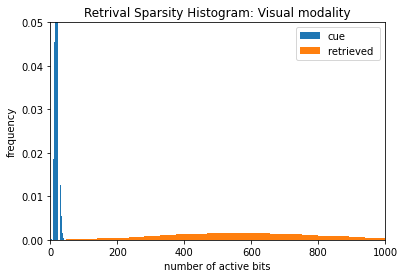

In: 19.90 (5.39)
Out: 603.71 (255.79)


In [20]:
""" Visualize how the sparsity of normal retrieval works"""
plot_sparsity_hist(noisy_codes.toarray(), "cue", title="Sparsity of retrieval: Visual modality", nbins=50)
plot_sparsity_hist(ret_noisy.toarray(), "retrieved ", title="Retrival Sparsity Histogram: Visual modality",nbins=50)
plt.show()

noisy_codes_mean = avg_bits_per_code(noisy_codes)
noisy_codes_std = std_bits_per_code(noisy_codes)

ret_noisy_mean = avg_bits_per_code(ret_noisy)
ret_noisy_std = std_bits_per_code(ret_noisy)

print(f"In: {noisy_codes_mean:.2f} ({noisy_codes_std:.2f})")
print(f"Out: {ret_noisy_mean:.2f} ({ret_noisy_std:.2f})")

adding noise: 100%|██████████| 1000/1000 [00:00<00:00, 1641.03data-sample/s]


---- prob = 0.75 ----
19.78, 5.12 -> 313.11, 156.86


adding noise: 100%|██████████| 1000/1000 [00:00<00:00, 1939.43data-sample/s]


---- prob = 0.5 ----
40.01, 8.40 -> 186.19, 83.70


adding noise: 100%|██████████| 1000/1000 [00:00<00:00, 2285.80data-sample/s]


---- prob = 0.25 ----
59.59, 11.40 -> 149.86, 60.90


adding noise: 100%|██████████| 1000/1000 [00:00<00:00, 3368.57data-sample/s]


---- prob = 0 ----
79.58, 14.45 -> 131.67, 49.85


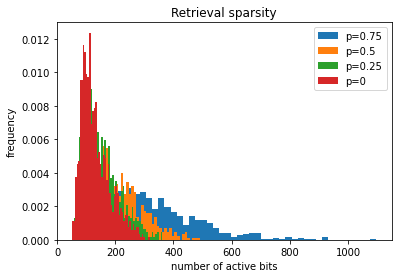

In [17]:
codes_small = codes[:1000]

for prob in [0.75, 0.5, 0.25, 0]:
    noisy = add_zero_noise(codes_small, prob)
    ret = wn.retrieve(noisy)
    print(f"---- prob = {prob} ----")
    print(f"{avg_bits_per_code(noisy):.2f}, {std_bits_per_code(noisy):.2f} -> {avg_bits_per_code(ret):.2f}, {std_bits_per_code(ret):.2f}")
    #plot_sparsity_hist(noisy.toarray(), "cue", title="Normal retrieval of codes")
    plot_sparsity_hist(ret.toarray(), f"p={prob}", title="Retrieval sparsity", nbins=50)


adding noise: 100%|██████████| 1000/1000 [00:00<00:00, 1361.71data-sample/s]


---- prob = 0.03 ----
81.91, 14.93 -> 66.68, 60.30


adding noise: 100%|██████████| 1000/1000 [00:00<00:00, 1939.40data-sample/s]


---- prob = 0.02 ----
81.22, 14.78 -> 81.12, 60.58


adding noise: 100%|██████████| 1000/1000 [00:00<00:00, 3555.74data-sample/s]


---- prob = 0.01 ----
80.40, 14.62 -> 104.27, 61.33


adding noise: 100%|██████████| 1000/1000 [00:00<00:00, 21333.01data-sample/s]


---- prob = 0.0 ----
79.58, 14.45 -> 131.67, 49.85


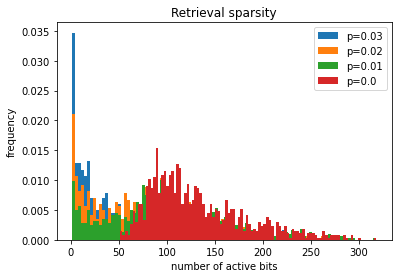

In [22]:
codes_small = codes[:1000]

for prob in [0.03, 0.02, 0.01, 0.0]:
    noisy = add_one_noise_relative(codes_small, prob)
    ret = wn.retrieve(noisy)
    print(f"---- prob = {prob} ----")
    print(f"{avg_bits_per_code(noisy):.2f}, {std_bits_per_code(noisy):.2f} -> {avg_bits_per_code(ret):.2f}, {std_bits_per_code(ret):.2f}")
    #plot_sparsity_hist(noisy.toarray(), "cue", title="Normal retrieval of codes")
    plot_sparsity_hist(ret.toarray(), f"p={prob}", title="Retrieval sparsity", nbins=100)


In [23]:
r1 = wn.retrieve(codes[:10000])
r2 = wn.retrieve(tst_codes)

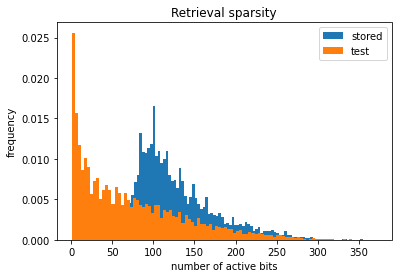

In [24]:
plot_sparsity_hist(r1.toarray(), f"stored", title="Retrieval sparsity", nbins=100)
plot_sparsity_hist(r2.toarray(), f"test", title="Retrieval sparsity", nbins=100)

adding noise: 100%|██████████| 10000/10000 [00:03<00:00, 2723.41data-sample/s]


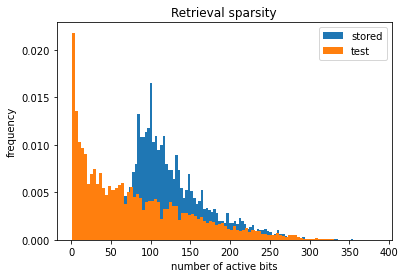

In [25]:
r3 = wn.retrieve(add_zero_noise(tst_codes, prob = 0.1))

plot_sparsity_hist(r1.toarray(), f"stored", title="Retrieval sparsity", nbins=100)
plot_sparsity_hist(r3.toarray(), f"test", title="Retrieval sparsity", nbins=100)

adding noise: 100%|██████████| 10000/10000 [00:04<00:00, 2184.30data-sample/s]


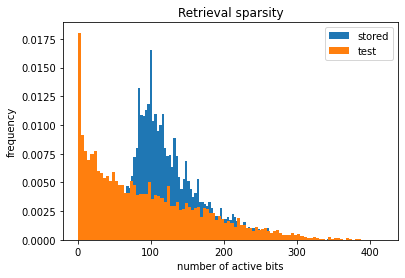

In [26]:
r4 = wn.retrieve(add_zero_noise(tst_codes, prob = 0.25))

plot_sparsity_hist(r1.toarray(), f"stored", title="Retrieval sparsity", nbins=100)
plot_sparsity_hist(r4.toarray(), f"test", title="Retrieval sparsity", nbins=100)

adding noise: 100%|██████████| 10000/10000 [00:06<00:00, 1658.03data-sample/s]


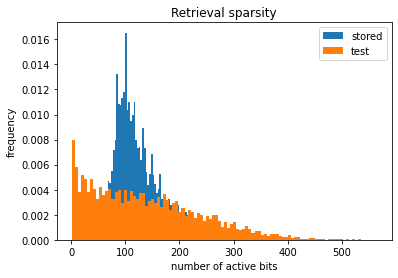

In [27]:
r5 = wn.retrieve(add_zero_noise(tst_codes, prob = 0.5))

plot_sparsity_hist(r1.toarray(), f"stored", title="Retrieval sparsity", nbins=100)
plot_sparsity_hist(r5.toarray(), f"test", title="Retrieval sparsity", nbins=100)

adding noise: 100%|██████████| 10000/10000 [00:06<00:00, 1604.01data-sample/s]


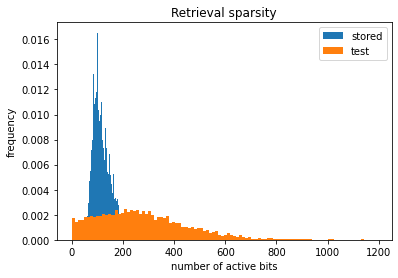

In [28]:
r6 = wn.retrieve(add_zero_noise(tst_codes, prob = 0.75))

plot_sparsity_hist(r1.toarray(), f"stored", title="Retrieval sparsity", nbins=100)
plot_sparsity_hist(r6.toarray(), f"test", title="Retrieval sparsity", nbins=100)

adding noise: 100%|██████████| 10000/10000 [00:06<00:00, 1531.10data-sample/s]


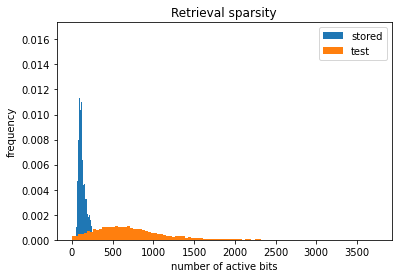

In [29]:
r7 = wn.retrieve(add_zero_noise(tst_codes, prob = 0.9))

plot_sparsity_hist(r1.toarray(), f"stored", title="Retrieval sparsity", nbins=100)
plot_sparsity_hist(r7.toarray(), f"test", title="Retrieval sparsity", nbins=100)

In [30]:
def empty_encoding(num_exs, desc_size):
    return np.zeros(shape=(num_exs, desc_size))

In [31]:
nxh_x = 100
nxh_Pc = 0.5
nxh_Pr = 0.0

descs = noisy_x_hot_encoding(lbls[:10000], nxh_x, nxh_Pc, nxh_Pr)
desc_size = descs.shape[1]
desCodes = join(descs, codes[:10000])

In [37]:
tst_descs = empty_encoding(10000, desc_size)
tst_desCodes = join(tst_descs, tst_codes)

In [ ]:
ret = wn.retrieve()